In [126]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import collections 
import time
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras

In [75]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [76]:
np.random.seed(42)

In [77]:
data_dir = "/content/drive/MyDrive/Hackathon/SmartFall_Dataset"

train = pd.read_csv('/content/drive/MyDrive/Hackathon/SmartFall_Dataset/SmartFall_Dataset/SmartFall Training.csv')
test = pd.read_csv('/content/drive/MyDrive/Hackathon/SmartFall_Dataset/SmartFall_Dataset/SmartFall Testing.csv')

In [134]:
test

,ms_accelerometer_x,ms_accelerometer_y,ms_accelerometer_z,outcome
0,0.986328,0.210938,-0.105957,0
1,0.977051,0.203125,-0.109375,0
2,0.977051,0.203125,-0.109375,0
3,0.944336,0.191162,-0.107422,0
4,0.808838,0.211670,-0.071045,0
...,...,...,...,...
91020,0.867188,0.416016,0.086426,0
91021,0.780518,0.477539,0.062256,0
91022,0.653076,0.355469,0.117920,0
91023,0.675293,0.513672,-0.014160,0


## Preprecessing

- sliding window size of 40
- if data contains all fall samples(25 samples) then, label as 'FALL'
- unless, it's all labelled as 'ADL'

In [104]:
n = 100
X_train, y_train = list(), list()

for i in tqdm(range(0, len(train)-n)):
    temp = list()
    
    temp.append(train[' ms_accelerometer_x'][i : i + n])
    temp.append(train[' ms_accelerometer_y'][i : i + n])
    temp.append(train[' ms_accelerometer_z'][i : i + n])
    
    cnt = collections.Counter(train['outcome'][i: i + n])
    num_adl = cnt[0]
    num_fall = cnt[1]
    
    if num_fall == 30:
        y_train.append(1)
    else:
        y_train.append(0)
    
    X_train.append(temp)

<ipython-input-104-908304e4b4a9>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(0, len(train)-n)):


  0%|          | 0/92681 [00:00<?, ?it/s]

In [131]:
n = 100
X_test_adl, X_test_fall, y_test_adl, y_test_fall = list(), list(), list(), list()
for i in tqdm(range(0, len(test) - n)):
    temp = list()
    
    temp.append(test[' ms_accelerometer_x'][i : i + n])
    temp.append(test[' ms_accelerometer_y'][i : i + n])
    temp.append(test[' ms_accelerometer_z'][i : i + n])
    
    cnt = collections.Counter(test['outcome'][i : i + n])
    num_adl = cnt[0]
    num_fall = cnt[1]
    
    if num_fall == 25:
        y_test_fall.append(1)
        X_test_fall.append(temp)
    else:
        y_test_adl.append(0)
        X_test_adl.append(temp)

<ipython-input-131-320528fdc6e1>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(0, len(test) - n)):


  0%|          | 0/90925 [00:00<?, ?it/s]

In [132]:
print(len(y_test_fall))
print(len(y_test_adl))

15224
75701


In [107]:
# to keep the balance between ADL and FALL data, used only part of ADL data

X_test_adl = X_test_adl[:3216]
y_test_adl = y_test_adl[:3216]

y_test = y_test_adl + y_test_fall
X_test = X_test_adl + X_test_fall

X_train = X_train + X_test
y_train = y_train + y_test

In [108]:
print('length of test data', len(X_test))

length of test data 18440


In [109]:
print('train data adl and fall ratio')
print('--------------------------------')
cnt_train = collections.Counter(y_train)
print('train data adl ratio: ', cnt_train[0])
print('train data fall ratio: ', cnt_train[1])
print('--------------------------------')

cnt_test = collections.Counter(y_test)
print('test data adl ratio: ', cnt_test[0])
print('test data fall ratio: ', cnt_test[1])

train data adl and fall ratio
--------------------------------
train data adl ratio:  71165
train data fall ratio:  39956
--------------------------------
test data adl ratio:  3216
test data fall ratio:  15224


## CNN/DENSE model declaration 


In [92]:
# from tensorflow.keras.layers import Input, Flatten, Conv1D, Embedding, Bidirectional, Dense

# model = keras.Sequential()

# input_shape=(128,40,3)
# # encoder
# model.add(Input(shape=input_shape[1:]))
# model.add(Flatten())
# model.add(Dense(20, input_shape = (256,), activation = 'relu'))
# model.add(Dense(15, activation = 'relu'))
# model.add(Dense(10, activation = 'relu'))

# # binary classifier as decoder
# model.add(Dense(name='classifier', units=1, activation='sigmoid'))

# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# model.summary()

In [117]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Reshape

model = keras.Sequential()

# encoder
model.add(Input(shape=(n, 3)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2, padding='same'))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2, padding='same'))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2, padding='same'))
model.add(Flatten())
model.add(Dense(units=20, activation='relu'))
model.add(Dense(units=15, activation='relu'))
model.add(Dense(units=10, activation='relu'))

# binary classifier as decoder
model.add(Dense(units=1, activation='sigmoid', name='classifier'))

#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_34 (Conv1D)          (None, 100, 64)           640       
                                                                 
 conv1d_35 (Conv1D)          (None, 100, 64)           12352     
                                                                 
 max_pooling1d_19 (MaxPoolin  (None, 50, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_36 (Conv1D)          (None, 50, 32)            6176      
                                                                 
 conv1d_37 (Conv1D)          (None, 50, 32)            3104      
                                                                 
 max_pooling1d_20 (MaxPoolin  (None, 25, 32)           0         
 g1D)                                                 

## Preparing datasets

In [118]:
X_train = np.asarray(X_train).reshape(-1, n, 3)
y_train = np.asarray(y_train).reshape(-1, )

X_test = np.asarray(X_test).reshape(-1, n, 3)
y_test = np.asarray(y_test).reshape(-1, )

In [119]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()

# y_train = enc.fit_transform(y_train)
# y_test = enc.fit_transform(y_test)

In [120]:
#X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1)

In [121]:
batch_size = 128

train_data = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(X_train), tf.convert_to_tensor(y_train)))
train_loader = train_data.shuffle(buffer_size=len(train_data)).batch(batch_size)

# valid_data = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(X_valid), tf.convert_to_tensor(y_valid)))
# valid_loader = valid_data.shuffle(buffer_size=len(valid_data)).batch(batch_size)

test_data = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(X_test), tf.convert_to_tensor(y_test)))
test_loader = test_data.shuffle(buffer_size=len(test_data)).batch(batch_size)


## Model training

In [122]:
input_dim = train_loader.element_spec[0].shape[2]
output_dim = 2
n_layers = 2
hidden_dim = 256

lr = 0.0001
n_epochs = 40
iterations_per_epoch = len(train_loader)
best_acc = 0.
patience, trials = 15, 0

criterion = tf.keras.losses.BinaryCrossentropy()
lr_schedule = tf.keras.experimental.CosineDecayRestarts(initial_learning_rate=lr, first_decay_steps=iterations_per_epoch * 2)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
epoch_times = []


In [123]:
model.compile(optimizer, criterion,metrics=['accuracy'])

In [124]:
%time history = model.fit(X_train, y_train, epochs=10, batch_size=batch_size, validation_split=0.2)

Epoch 1/10
695/695 [==============================] - 27s 36ms/step - loss: 0.2741 - accuracy: 0.8849 - val_loss: 0.1552 - val_accuracy: 0.9430
Epoch 2/10
695/695 [==============================] - 24s 34ms/step - loss: 0.1275 - accuracy: 0.9530 - val_loss: 0.1322 - val_accuracy: 0.9568
Epoch 3/10
695/695 [==============================] - 24s 35ms/step - loss: 0.1185 - accuracy: 0.9572 - val_loss: 0.1358 - val_accuracy: 0.9576
Epoch 4/10
695/695 [==============================] - 24s 35ms/step - loss: 0.0989 - accuracy: 0.9661 - val_loss: 0.1828 - val_accuracy: 0.9283
Epoch 5/10
695/695 [==============================] - 24s 34ms/step - loss: 0.0847 - accuracy: 0.9713 - val_loss: 0.2081 - val_accuracy: 0.9195
Epoch 6/10
695/695 [==============================] - 24s 35ms/step - loss: 0.0770 - accuracy: 0.9743 - val_loss: 0.1518 - val_accuracy: 0.9470
Epoch 7/10
695/695 [==============================] - 24s 35ms/step - loss: 0.0736 - accuracy: 0.9753 - val_loss: 0.1548 - val_accuracy:

In [125]:
test_loss, test_accuracy = model.evaluate(test_loader, batch_size=batch_size)
test_accuracy

145/145 [==============================] - 2s 10ms/step - loss: 0.1451 - accuracy: 0.9560


0.9560195207595825

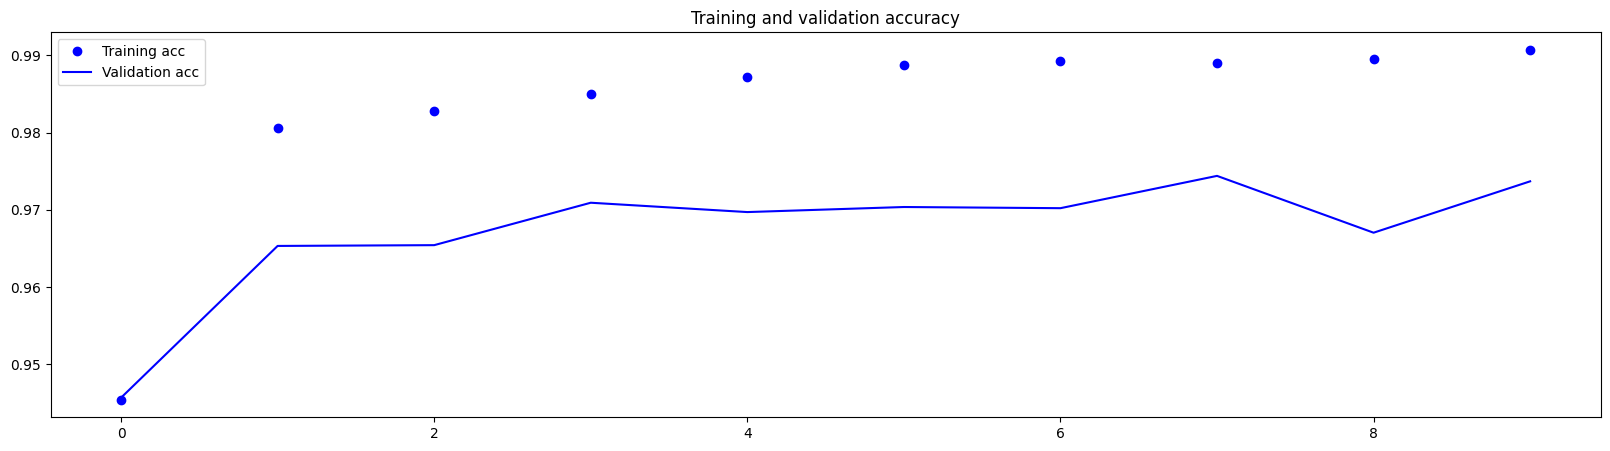

In [102]:
def plot_history(history, samples=10, init_phase_samples=None):
    epochs = history.params['epochs']
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    every_sample =  int(epochs / samples)
    acc = pd.DataFrame(acc).iloc[::every_sample, :]
    val_acc = pd.DataFrame(val_acc).iloc[::every_sample, :]

    fig, ax = plt.subplots(figsize=(20,5))

    ax.plot(acc, 'bo', label='Training acc')
    ax.plot(val_acc, 'b', label='Validation acc')
    ax.set_title('Training and validation accuracy')
    ax.legend()

plot_history(history)

In [72]:
model.save('model.h5')
loaded_model = keras.models.load_model('model.h5')
result = loaded_model(tf.random.uniform((1,40,3))).numpy()
result

array([[5.4317474e-11]], dtype=float32)

In [73]:
from tensorflow import lite

converter = lite.TFLiteConverter.from_keras_model(loaded_model)

converter._experimental_default_to_single_batch_in_tensor_list_ops = True

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.experimental_new_converter=True
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS] 

tfmodel = converter.convert()
open('model.tflite', 'wb').write(tfmodel)

49808

In [ ]:
# run_model = tf.function(lambda x: model(x))
# # This is important, let's fix the input size.
# BATCH_SIZE = 1
# STEPS = 40
# INPUT_SIZE = 3
# concrete_func = run_model.get_concrete_function(
#     tf.TensorSpec([BATCH_SIZE, STEPS, INPUT_SIZE], model.inputs[0].dtype))

# # model directory.
# MODEL_DIR = "keras_lstm"
# model.save(MODEL_DIR, save_format="tf", signatures=concrete_func)

# converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)
# tflite_model = converter.convert()
# open('model1.tflite', 'wb').write(tfmodel)

In [ ]:
import numpy as np
import tensorflow as tf

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="model1.tflite")
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Prepare input data
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)

# Set input data
interpreter.set_tensor(input_details[0]['index'], input_data)

# Run inference
interpreter.invoke()

# Get output data
output_data = interpreter.get_tensor(output_details[0]['index'])


In [ ]:
output_details

[{'name': 'StatefulPartitionedCall:0',
  'index': 34,
  'shape': array([1, 1], dtype=int32),
  'shape_signature': array([-1,  1], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]